# Домашнее задание №2 "Элементарные алгоритмы обработки временных рядов"


### Задание 1.
### Практика 7. Напишите функцию, которая подбирает оптимальные параметры для double_ema и ряда Monthly Boston armed robberies

### Задание 2.

### Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

# Часть 1.

In [74]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [2]:
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")

In [3]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [4]:
def plot_dema(alpha, beta):
    dema = double_ema(robberies_in_boston["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(11, 6))
        plt.plot(robberies_in_boston["Count"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='3', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [5]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [6]:
series = robberies_in_boston["Count"]
train, test, val = series[:80], series[80:105], series[105:]

In [7]:
def mse(X):
    alpha, beta = X
    result = double_ema(train, alpha, beta)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [8]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [9]:
print(opt)

      fun: 9144.386706249725
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0001819 ,  0.00090949])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 17
   status: 0
  success: True
        x: array([0.72367886, 0.20869432])


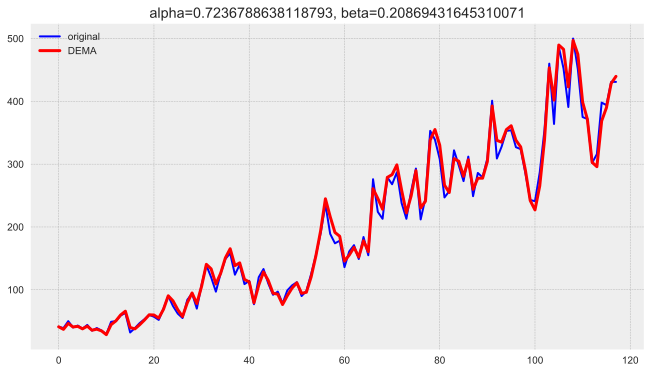

In [10]:
plot_dema(opt.x[0], opt.x[1])

# Часть 2

**Возьмем в качестве нашего ряда "weekly-closings-of-the-dowjones-.csv"**

In [11]:
indData = pd.read_csv('Series/weekly-closings-of-the-dowjones-.csv', sep=',')
indData.columns = ['Month', 'Count']
series = indData['Count']

In [12]:
series.head()

0    890.19
1    901.80
2    888.51
3    887.78
4    858.43
Name: Count, dtype: float64

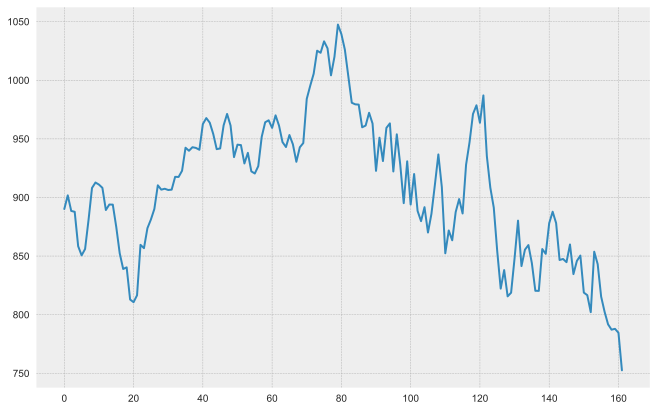

In [13]:
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series)

# 2.1 Нестационарный ряд.

In [14]:
train, test = series[:125], series[125:]

## 2.1.1. MA (Скользящее среднее )

In [15]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [16]:
def predict(series, N, n_pred, method=None):
    new_series = series.copy()
    
    if method=='ma':
        for _ in range(n_pred):
            new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
        return new_series
    
    elif method=='wma':
        weights = np.arange(1, N+1)
        new_series = series.copy()
        result = series.rolling(N).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
        for _ in range(n_pred):
            res = pd.Series([(np.array(new_series[-N:])*weights/weights.sum()).sum()])
            new_series = new_series.append(res, ignore_index=True)
            result = result.append(res, ignore_index=True)
        return result

In [17]:
def mean_percentage_squared_error(approximate, series):
    
    return 100*(((series - approximate)/series)**2).sum()/len(series)

In [18]:
def mpse(series, n, method, train=[], n_pred=0, pred=False):
    
    if pred==True:
        result = predict(train, n, n_pred, method=method)
        result = result[-n_pred:]
        error = mean_percentage_squared_error(result, test)
    else:
        result = moving_average(series, n)
        error = mean_percentage_squared_error(result, series)
    return error

def fminimize(series, n_list, method, train=[], n_pred=0, pred=False):
    errors = []
    for i in n_list:
        error = mpse(series, i, method, train, n_pred, pred)
        errors.append(error)
    return min(errors), n_list[np.argmin(errors)]

In [19]:
n_list = np.arange(2, 100)

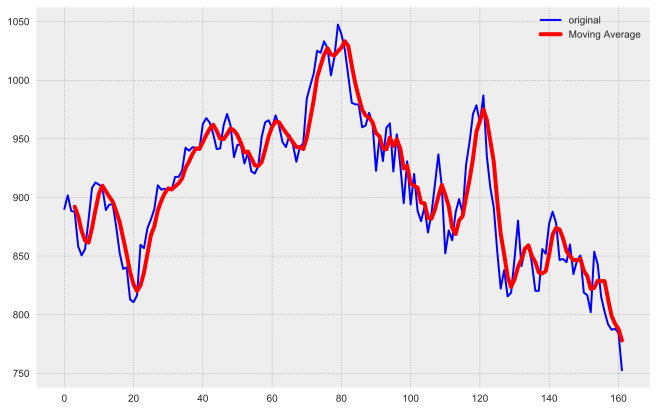

In [20]:
ser = moving_average(series, 4)
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [21]:
print('Таким образом, MPSE = {:.5f}%, и оптимальная ширина окна для MA: {}'
      .format(fminimize(series, n_list, 'ma', train, len(test), True)[0],
              fminimize(series, n_list, 'ma', train, len(test), True)[1]))

Таким образом, MPSE = 0.74808%, и оптимальная ширина окна для MA: 2


In [22]:
opt_n = fminimize(series, n_list, 'ma', train, len(test), True)[1]

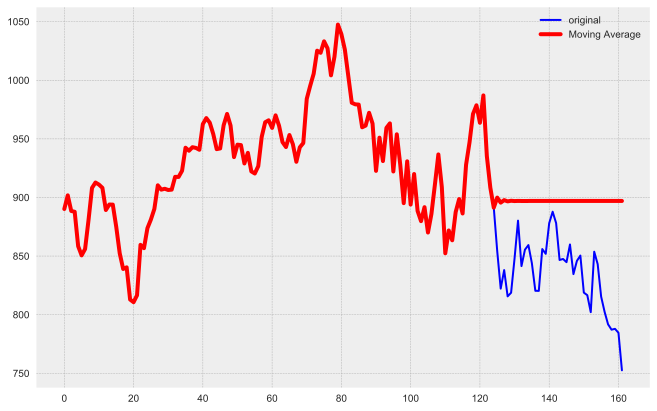

In [23]:
pred = predict(train, opt_n, len(test), method='ma')
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(pred, color='red', linewidth='4', label='Moving Average')
    plt.legend()

## 2.1.2. Взвешенная скользящее среднее

In [24]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

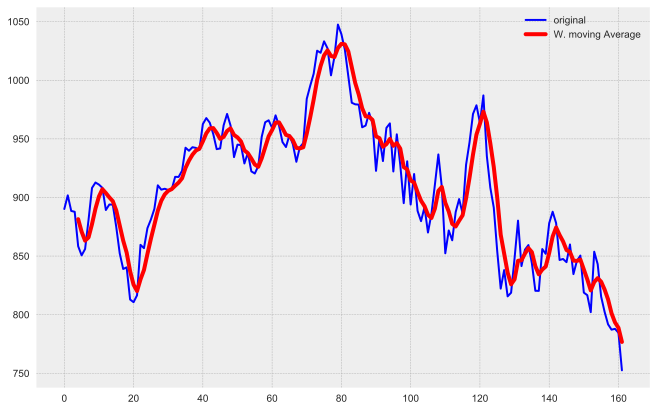

In [25]:
f = lambda x: x+1
n = 5
ws = f(np.linspace(1, n, n))

ser = weighted_moving_average(series, n, ws)
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='W. moving Average')
    plt.legend()

In [26]:
print('Таким образом, MPSE = {:.5f}%, и оптимальная ширина окна для MA: {}'
      .format(fminimize(series, n_list, 'wma', train, len(test), True)[0],
              fminimize(series, n_list, 'wma', train, len(test), True)[1]))

Таким образом, MPSE = 0.72149%, и оптимальная ширина окна для MA: 2


In [27]:
fminimize(series, n_list, 'wma', train=train, n_pred=len(test), pred=True)

(0.7214854968655713, 2)

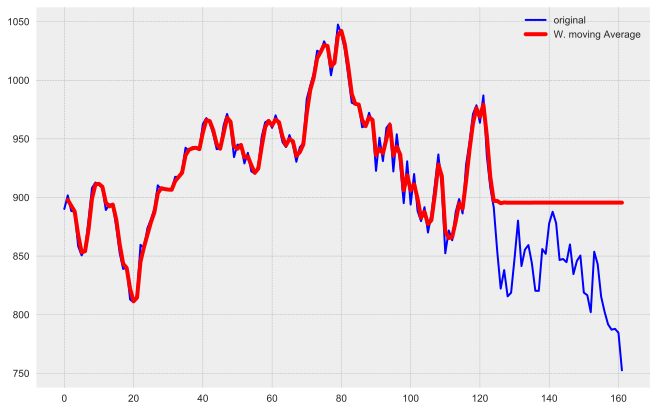

In [28]:
pred = predict(train, opt_n, len(test), method='wma')
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(pred, color='red', linewidth='4', label='W. moving Average')
    plt.legend()

## 2.1.3. Экспоненциальное сглаживание.

In [29]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

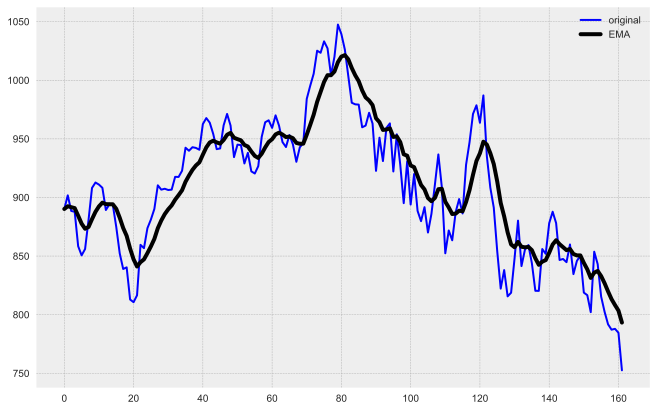

In [30]:
ema = exponential_moving_average(series, 0.2)
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [31]:
def predict_ema(series, alpha, n_pred):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return pd.Series(result)

In [32]:
def mse_ema(X):
    alpha = X
    result = predict_ema(train, alpha, len(test))
    predictions = result[-len(test):]
    error = mean_percentage_squared_error(predictions, test)
    return error

In [33]:
opt = minimize(mse_ema, x0=[0.3], method="L-BFGS-B", 
               bounds = ((0.3, 5),))

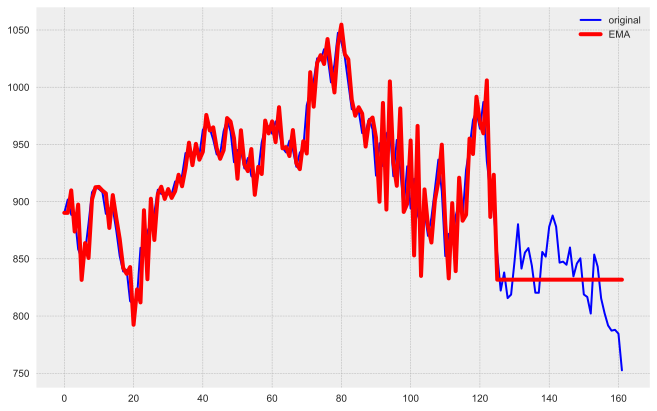

In [34]:
alpha = opt.x[0]

pred = predict_ema(train, alpha, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(pred, color='red', linewidth='4', label='EMA')
    plt.legend()

In [35]:
print('Таким образом, MPSE = {:.5f}%, и параметр альфа: {}'
      .format(mean_percentage_squared_error(pred, test), alpha))

Таким образом, MPSE = 0.13288%, и параметр альфа: 1.689188887971411


## 2.1.4. Двойное экспоненциальное сглаживание.

In [36]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [37]:
def plot_dema(alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(11, 7))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

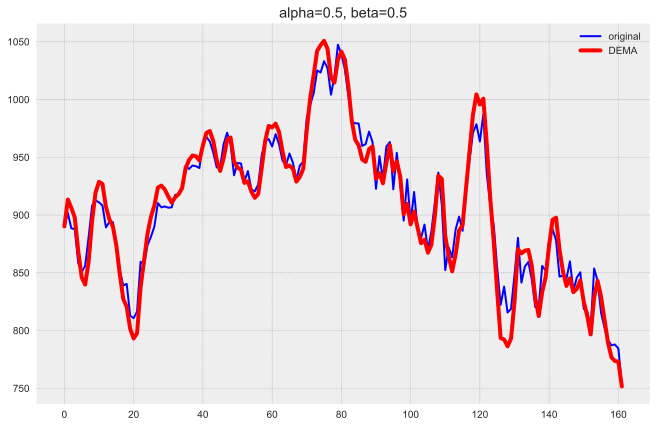

In [38]:
plot_dema(0.5, 0.5)

In [39]:
def predict_dema(series, alpha, beta, n_pred):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_pred):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.Series(result)

def mse_dema(X):
    alpha, beta = X
    result = predict_dema(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_percentage_squared_error(predictions, test)
    return error

In [40]:
opt = minimize(mse_dema, x0=[0, 0], method="L-BFGS-B", 
               bounds = ((0, 1),(0, 1)))
opt

      fun: 0.11568502865546576
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.74883102e-02,  2.45636844e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 6
   status: 0
  success: True
        x: array([1.        , 0.07059055])

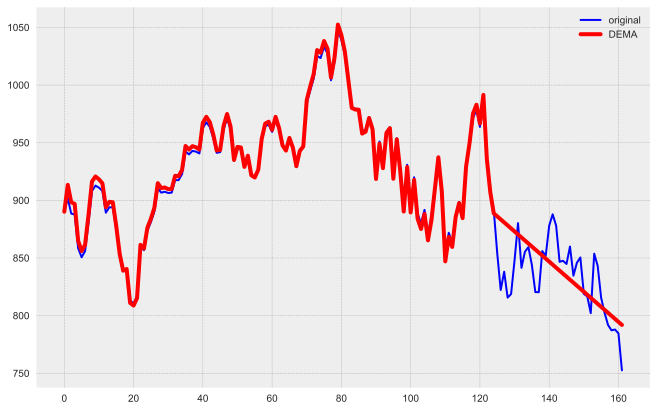

In [41]:
alpha, beta = opt.x[0], opt.x[1]

pred = predict_dema(train, alpha, beta, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(pred, color='red', linewidth='4', label='DEMA')
    plt.legend()

In [42]:
print('Таким образом, MPSE = {:.5f}%, параметр альфа: {}, параметр бета: {:.3f}'
      .format(mean_percentage_squared_error(pred, test), alpha, beta))

Таким образом, MPSE = 0.11569%, параметр альфа: 1.0, параметр бета: 0.071


## 2.1.5. Хольт-Винтерс.

In [43]:
def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals



def predict_tema(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return pd.Series(result)

def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [44]:
mpse_list = []
for i in range(1, 100):
    for k in np.arange(0, 1, 0.05):
        pred = predict_tema(train, i, alpha, beta, k, len(test))
        mpse_list.append((mean_percentage_squared_error(pred, test)))
n = np.argmin(mpse_list)//20 + 1
gamma = (np.argmin(mpse_list) + 1)/20 - (n - 1)

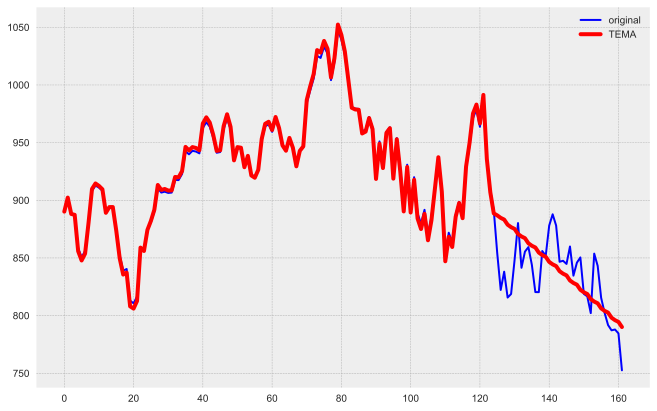

In [45]:
pred = predict_tema(train, n, alpha, beta, gamma, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(pred, color='red', linewidth='4', label='TEMA')
    plt.legend()

In [46]:
mean_percentage_squared_error(pred, test)

0.11841677146031987

**Так как у нашего ряда отсутствует сезонность, метод Хольт-Винтерса не улучшает наше предсказание на тестовых данных. Но как и ожидалось приближает наш ряд этот метод наилучшим образом.**

# 2.1 Cтационарный ряд.

## Получим стационарный ряд

In [47]:
def tsplot(y, lags=None, figsize=(10, 10), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

## Для начала посмотрим на коррелограммы для оригинального ряда. 

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


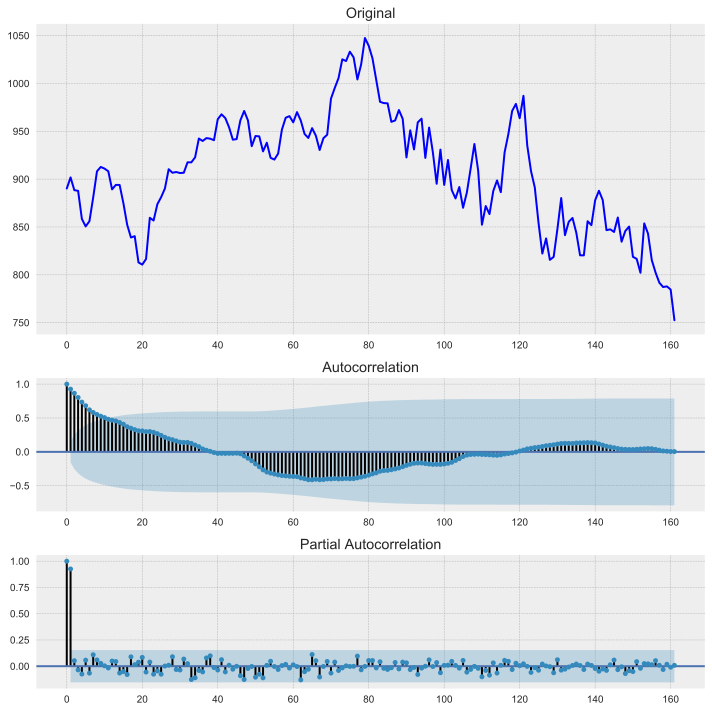

In [48]:
series = indData['Count']

tsplot(series)

## Применим пеобразования Бокса-Кокса. ($\lambda = 0$)

Results of Dickey-Fuller Test:
Test Statistic                  -1.210369
p-value                          0.669119
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


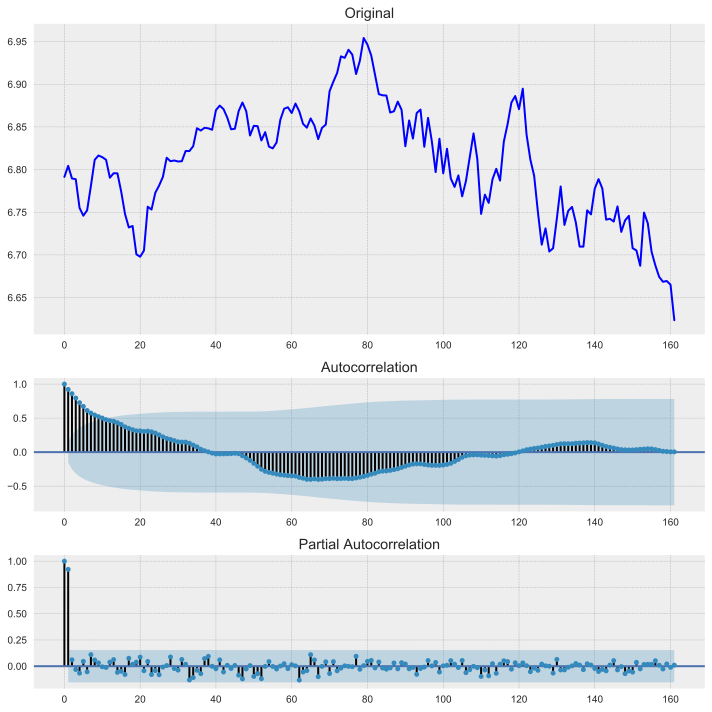

In [49]:
series = boxcox(series, 0)

tsplot(series)

## Избавимся от ярко выраженного тренда с помощью дифф-ия.

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


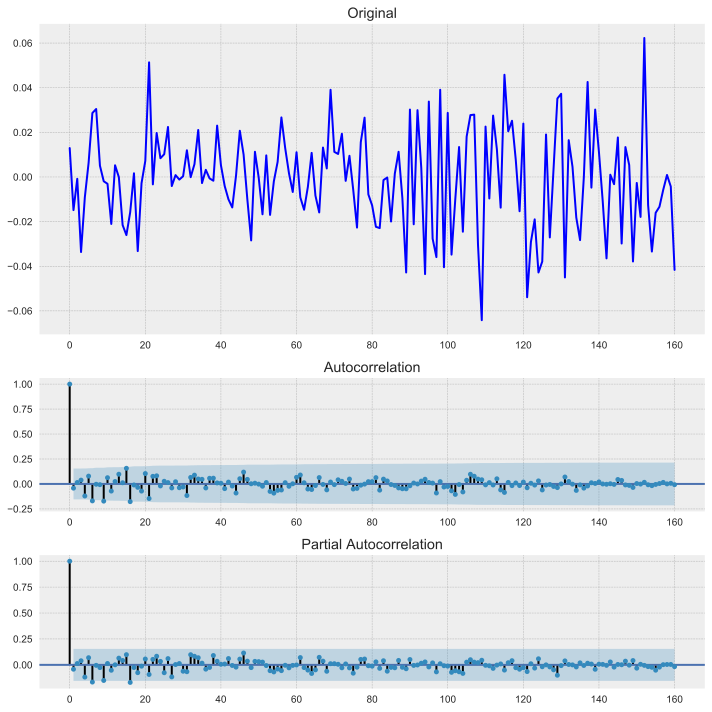

In [50]:
series = series[1:] - series[:-1]

tsplot(series)

## p-value < 0.05 => Мы получили стационарный ряд.

In [51]:
series = pd.Series(series)
train, test = series[:125], series[125:]

## 2.2.1. MA (Скользящее среднее )

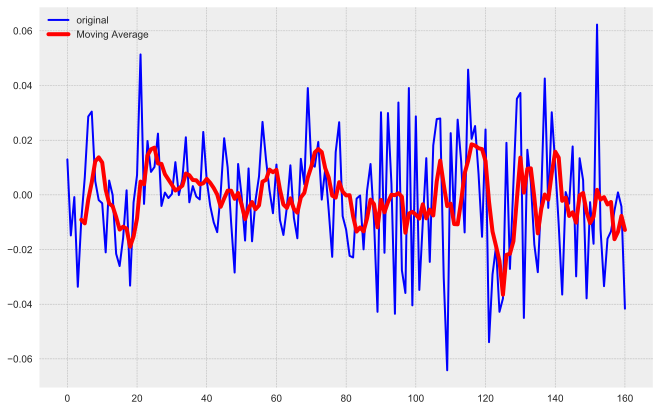

In [52]:
ser = moving_average(series, 5)
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [53]:
def mpse(series, n, method, train=[], n_pred=0, pred=False):
    
    if pred==True:
        result = predict(train, n, n_pred, method=method)
        result = result[-n_pred:]
        error = mean_squared_error(result, test)
    else:
        result = moving_average(series, n)
        error = mean_squared_error(result, series)
    return error

def fminimize(series, n_list, method, train=[], n_pred=0, pred=False):
    errors = []
    for i in n_list:
        error = mpse(series, i, method, train, n_pred, pred)
        errors.append(error)
    return min(errors), n_list[np.argmin(errors)]

In [54]:
n_list = np.arange(1, 15, 1)

In [55]:
print('Таким образом, MSE = {:.5f}, и оптимальная ширина окна для MA: {}'
      .format(fminimize(series, n_list, 'ma', train, len(test), True)[0],
              fminimize(series, n_list, 'ma', train, len(test), True)[1]))

Таким образом, MSE = 0.00067, и оптимальная ширина окна для MA: 14


In [56]:
opt_n = fminimize(series, n_list, 'ma', train, len(test), True)[1]

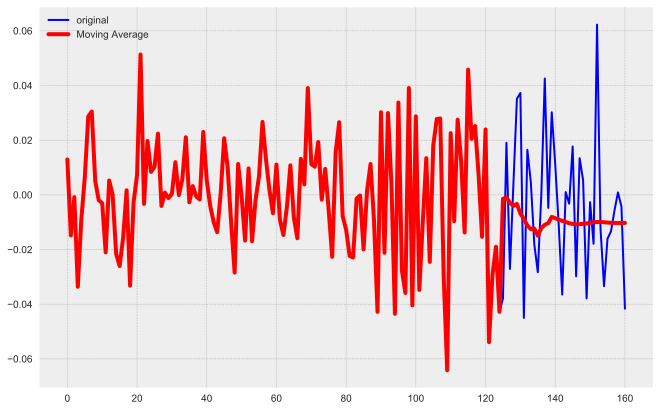

In [57]:
pred = predict(train, opt_n, len(test), method='ma')
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(pred, color='red', linewidth='4', label='Moving Average')
    plt.legend()

## 2.2.2. WMA ( Взв. скользящее среднее )

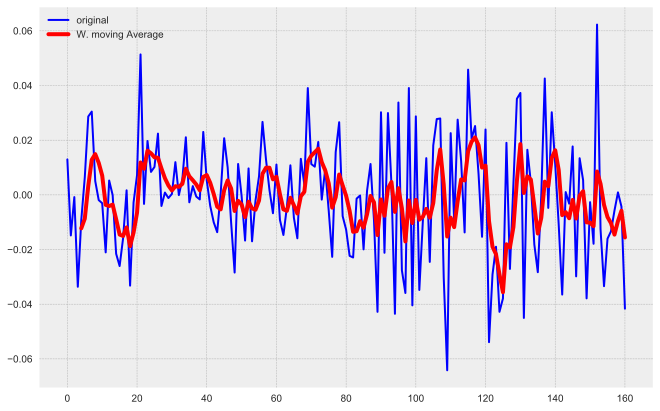

In [58]:
f = lambda x: x+1
n = 5
ws = f(np.linspace(1, n, n))

ser = weighted_moving_average(series, n, ws)
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='W. moving Average')
    plt.legend()

In [59]:
print('Таким образом, MSE = {:.5f} и оптимальная ширина окна для MA: {}'
      .format(fminimize(series, n_list, 'wma', train, len(test), True)[0],
              fminimize(series, n_list, 'wma', train, len(test), True)[1]))

Таким образом, MSE = 0.00080 и оптимальная ширина окна для MA: 14


In [60]:
opt_n = fminimize(series, n_list, 'wma', train=train, n_pred=len(test), pred=True)[1]

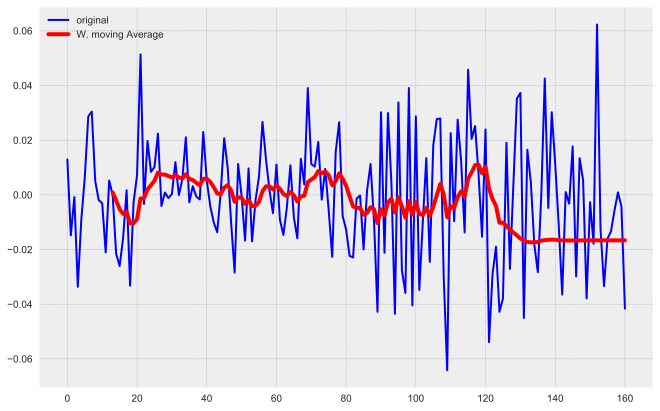

In [61]:
pred = predict(train, opt_n, len(test), method='wma')
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(pred, color='red', linewidth='4', label='W. moving Average')
    plt.legend()

## 2.2.3. Экспоненциальное сглаживание.

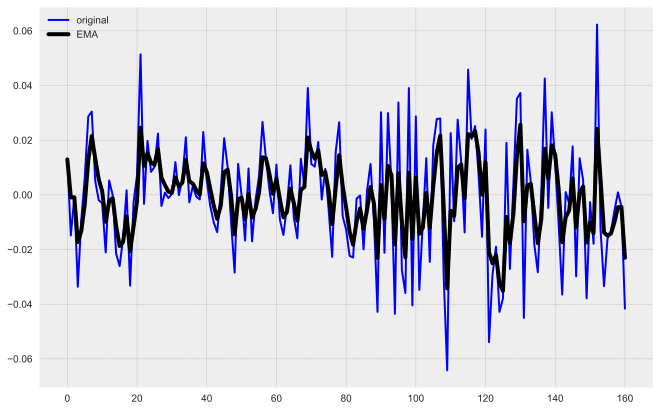

In [62]:
ema = exponential_moving_average(series, 0.5)
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [63]:
opt = minimize(mse_ema, x0=[0.1], method="L-BFGS-B", 
               bounds = ((0.1, 5),))

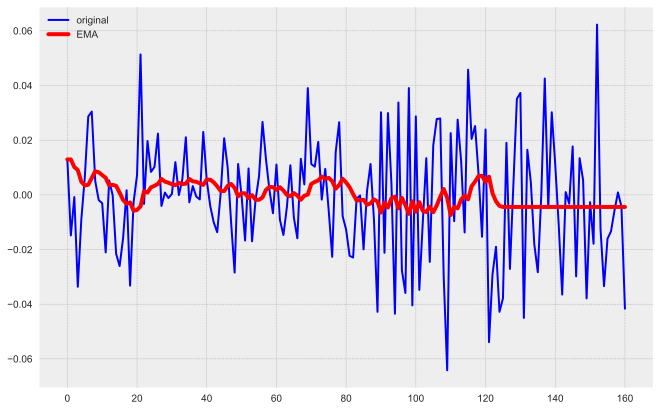

In [64]:
alpha = opt.x[0]

pred = predict_ema(train, alpha, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(pred, color='red', linewidth='4', label='EMA')
    plt.legend()

In [65]:
print('Таким образом, MPSE = {:.5f} и параметр альфа: {}'
      .format(mean_squared_error(pred[-len(test):], test), alpha))

Таким образом, MPSE = 0.00064 и параметр альфа: 0.1


## 2.2.4. Двойное экспоненциальное сглаживание.

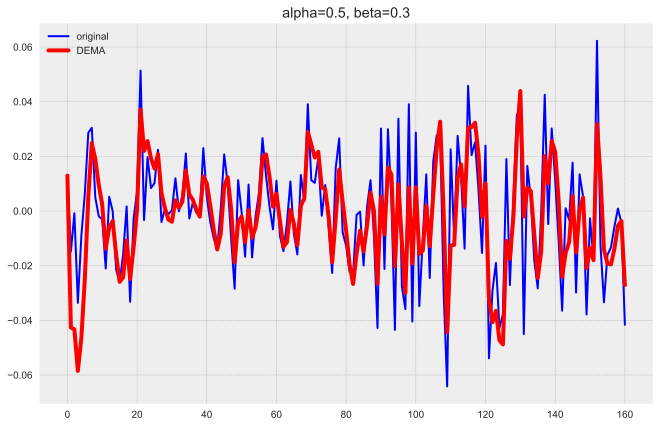

In [66]:
plot_dema(0.5, 0.3)

In [67]:
def mse_dema(X):
    alpha, beta = X
    result = predict_dema(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [68]:
opt = minimize(mse_dema, x0=[0, 0], method="L-BFGS-B", 
               bounds = ((0, 0.9),(0, 0.9)))
opt

      fun: 0.0006256209006760419
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.21105122e-05, 8.98823984e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 156
      nit: 32
   status: 0
  success: True
        x: array([0.05957754, 0.04826488])

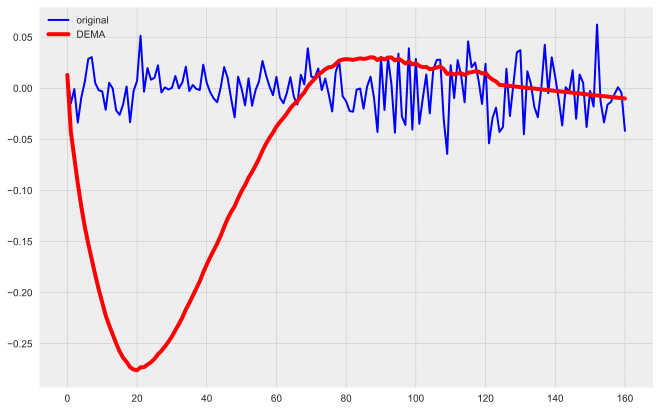

In [69]:
alpha, beta = opt.x[0], opt.x[1]

pred = predict_dema(train, alpha, beta, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(pred, color='red', linewidth='4', label='DEMA')
    plt.legend()

In [70]:
print('Таким образом, MSE = {:.5f}, параметр альфа: {}, параметр бета: {:.3f}'
      .format(mean_squared_error(pred[-len(test):], test), alpha, beta))

Таким образом, MSE = 0.00063, параметр альфа: 0.05957754482833009, параметр бета: 0.048


**Несмотря на то, что MSE несколько меньше, чем для скользящего среднего, вид самой кривой совсем не близок к реальному ряду.**

## 2.2.5. Хольт-Винтерс.

In [71]:
mse_list = []
for i in range(1, 100):
    for k in np.arange(0, 1, 0.05):
        pred = predict_tema(train, i, alpha, beta, k, len(test))
        mse_list.append((mean_squared_error(pred[-len(test):], test)))
n = np.argmin(mse_list)//20 + 1
gamma = (np.argmin(mse_list) + 1)/20 - (n - 1)

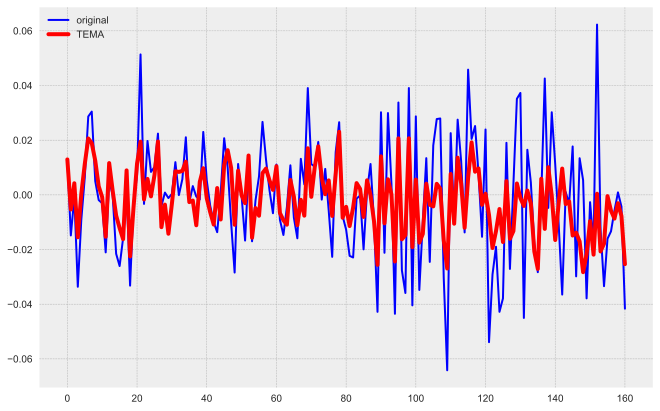

In [72]:
pred = predict_tema(train, n, alpha, beta, gamma, len(test))
with plt.style.context('bmh'):
    plt.figure(figsize=(11, 7))
    plt.plot(series, color='blue',label='original')
    plt.plot(pred, color='red', linewidth='4', label='TEMA')
    plt.legend()

In [73]:
print('Таким образом, MSE = {:.5f}, параметр альфа: {:.3f}, параметр бета: {:.3f}, параметр гамма: {:.3f}'
      .format(mean_squared_error(pred[-len(test):], test), alpha, beta, gamma))

Таким образом, MSE = 0.00059, параметр альфа: 0.060, параметр бета: 0.048, параметр гамма: 0.400


# Итог

**Для стационарного ряда, наилучшей моделью оказалась модель Хольта-Винтерса. Для нестационарного ряда DEMA, а Хольта-Винтерса оказался менее эффективен из-за отсутствия у ряда сезонности. Но в целом все модели не особенно эффективны для предсказаний, но хорошо работают для приближения временных рядом**